# RecSys
Modelo do tipo recuperação

## Importando bibliotecas necessárias

In [1]:
from sklearn import model_selection, metrics, preprocessing
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

Configurando dispositivo para utilizar GPU se possível; caso contrário, CPU

In [111]:
# mode = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device('cpu')
device

device(type='cpu')

In [112]:
torch.set_default_device(device)

## Carregando dados do dataset de avaliações de filmes

In [113]:
df_olist_txn = pd.read_csv('data/olist/rfzd_olist_transactions.csv')
df_olist_txn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100965 entries, 0 to 100964
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   customer_id               100965 non-null  object
 1   product_id                100965 non-null  object
 2   customer_zip_code_prefix  100965 non-null  int64 
 3   product_category_name     100965 non-null  object
 4   purchase_count            100965 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 3.9+ MB


In [114]:
df_olist_txn.sample(5)

,customer_id,product_id,customer_zip_code_prefix,product_category_name,purchase_count
47355,e60547efaf733493502a83561634b84d,d2bea3c01e172037caa99b2d138f39d0,97105,eletroportateis,1
53366,0525fa756013f1d648c20c8892bdea3e,7fb04722aba7a2b632bac8f9819796f3,5884,beleza_saude,1
34228,8a9e3fa1b04cb91e2a8565cc5927c4a7,1f30aacc69904c0d0bf8d05cb2abef72,1229,cama_mesa_banho,1
88382,b201351377dd577182a072e880c2c7ae,363218ba55c610b750224f90bdd34be1,18095,cama_mesa_banho,1
39684,bee5ac61e1c115db72e7c6843a3d1932,827f677ed9cd1e18a5f4e8ecd4eb7489,7081,telefonia,1


Checando distribuição de compras (de 1 a 20) em porcentagem

In [115]:
df_olist_txn['purchase_count'].value_counts(normalize=True) * 100

purchase_count
1     93.078790
2      5.256277
3      0.930025
4      0.380330
6      0.168375
5      0.163423
10     0.004952
7      0.003962
9      0.001981
8      0.001981
20     0.001981
12     0.001981
15     0.001981
14     0.001981
13     0.000990
11     0.000990
Name: proportion, dtype: float64

In [116]:
df_olist_txn['has_purchased'] = df_olist_txn['purchase_count'].map(lambda x: 1 if x >= 1 else 0)

In [117]:
df_olist_txn['has_purchased'].value_counts(normalize=True) * 100

has_purchased
1    100.0
Name: proportion, dtype: float64

## Preprocessamento dos dados para a geração de embeddings

Remapeando IDs para que fiquem sequênciais e incrementais

In [118]:
labels_customer = preprocessing.LabelEncoder()
labels_products = preprocessing.LabelEncoder()
labels_zip_code = preprocessing.LabelEncoder()
labels_category = preprocessing.LabelEncoder()

In [119]:
df_olist_txn['customer_id'] = labels_customer.fit_transform(df_olist_txn['customer_id'].values)
df_olist_txn['product_id'] = labels_products.fit_transform(df_olist_txn['product_id'].values)
df_olist_txn['customer_zip_code_prefix'] = labels_zip_code.fit_transform(df_olist_txn['customer_zip_code_prefix'].values)
df_olist_txn['product_category_name'] = labels_category.fit_transform(df_olist_txn['product_category_name'].values)


In [120]:
df_olist_txn.sample(5)

,customer_id,product_id,customer_zip_code_prefix,product_category_name,purchase_count,has_purchased
20173,36964,17187,9778,12,2,1
29635,66051,27128,2787,11,1,1
12811,54762,14906,1543,63,1,1
52378,3557,21724,5662,54,1,1
84674,35576,10665,5828,66,1,1


Dividindo dataset entre conjunto de treinamento, validação e teste

In [121]:
df_train, df_rest = model_selection.train_test_split(
    df_olist_txn,
    train_size=0.7,
    random_state=12
)

df_val, df_test = model_selection.train_test_split(
    df_rest,
    test_size=0.5,
    random_state=12
)

Configurando dataset para o treinamento do modelo

In [122]:
class OlistDataset(Dataset):
    '''
    Classe criada com o intuito de ajustar o dataset pandas ao
    treinamento de modelos utilizando o PyTorch, especialmente do que se
    diz respeito à utilização de lotes (batches) durante o treinamento.
    '''
    def __init__(self, customers, products, purchases):
        self.customers = customers
        self.products = products
        self.purchases = purchases

    def __len__(self):
        return (len(self.customers))
    
    def __getitem__(self, item):

        customers = self.customers[item]
        products = self.products[item]
        purchases = self.purchases[item]

        return {
            "customers": torch.tensor(customers, dtype=torch.long),
            "products": torch.tensor(products, dtype=torch.long),
            "purchases": torch.tensor(purchases, dtype=torch.long),
        }

Criando datasets de treinamento e teste

In [123]:
train_dataset = OlistDataset(
    customers=df_train['customer_id'].values,
    products=df_train['product_id'].values,
    purchases=df_train['has_purchased'].values
)

val_dataset = OlistDataset(
    customers=df_val['customer_id'].values,
    products=df_val['product_id'].values,
    purchases=df_val['has_purchased'].values
)

test_dataset = OlistDataset(
    customers=df_test['customer_id'].values,
    products=df_test['product_id'].values,
    purchases=df_test['has_purchased'].values
)

Ajustando dataset para ser utilizado pelo PyTorch como um iterável que retorna lotes de dados a cada iteração

In [124]:
BATCH_SIZE = 8

In [125]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Após isso, toda vez que o DataLoader for requisitado, ele retornará um lote (batch) de 8 itens

In [126]:
dataiter = iter(train_loader)
next(dataiter)

{'customers': tensor([33869, 72519, 75236, 49671, 43122, 67794, 22717, 91613]),
 'products': tensor([20809, 17323, 13813, 10344,  9567, 14037,  2872, 31177]),
 'purchases': tensor([1, 1, 1, 1, 1, 1, 1, 1])}

## Criando modelo de RecSys

Criando modelo de RecSys no estilo de torre-dupla

In [127]:
class OlistRecSys(nn.Module):
    '''
    Classe criada com o intuito de modelar a estrutura de torre-dupla,
    isto é, um dos modelos clássicos de RecSys baseado em filtragem
    colaborativa por meio de redes neurais.
    '''
    def __init__(self, n_customers, n_products, embedding_size = 32):
        super().__init__()
        # definindo embedding para clientes e produtos
        self.customer_embedding = nn.Embedding(n_customers, embedding_size)
        self.products_embedding = nn.Embedding(n_products, embedding_size)
        # definindo camada de saída como um neurônio
        self.output_layer = nn.Linear(embedding_size * 2, 1)

    def forward(self, customers, products):
        # criando camada de entrada a partir de embeddings de clientes e produtos
        customer_embeddings = self.customer_embedding(customers)
        products_embeddings = self.products_embedding(products)
        # concatenando embeddings de clientes e produtos
        concat_embeddings = torch.cat([customer_embeddings, products_embeddings], dim=1)
        output = self.output_layer(concat_embeddings)
        return output

Contando quantidade de clientes e produtos distintos envolvidos em compras

In [128]:
n_customers = len(labels_customer.classes_)
n_products = len(labels_products.classes_)
n_customers, n_products

(97277, 32341)

Instanciando modelo RecSys, configurando otimizador, taxa de aprendizado e função custo

In [129]:
STEP_SIZE = 4

In [130]:
model = OlistRecSys(n_customers, n_products).to(device)

optimizer = torch.optim.Adam(model.parameters())
scheaduler = torch.optim.lr_scheduler.StepLR(optimizer, STEP_SIZE, gamma=0.7)
loss_function = nn.MSELoss()

Criando o ciclo de treinamento

In [131]:
epochs = 1
total_loss = 0
plot_steps = 5000
step_count = 0
all_losses_list = []

In [132]:
model.to(device).train()

for epoch_index in range(epochs):
    for index, train_data in enumerate(train_loader):
        # calculando tamanho do lote retornado
        batch_length = len(train_data['customers'])
        # predições do modelo (y-predito)
        output = model(train_data['customers'], train_data['products'])
        # reformatando y-verdeiro para fical igual ao formato da saída do modelo y predito
        purchases = train_data['purchases'].view(batch_length, -1).to(torch.float32)
        # calculando o erro do modelo
        loss = loss_function(output, purchases)
        # somando erro do modelo ao longo dos passos de treinamento
        total_loss += loss.sum().item()
        # executando ajuste dos pesos no modelo via algoritmo de retropropagação
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # contando quantidade de instâncias utilizadas a cada iteração do treinamento
        step_count += batch_length

        if (step_count % plot_steps == 0):
            average_loss = total_loss / ( batch_length * plot_steps)
            print(f'epoch {epoch_index} loss at step: {step_count} is {average_loss}')
            all_losses_list.append(average_loss)
            total_loss = 0

epoch 0 loss at step: 5000 is 0.008433204882033168
epoch 0 loss at step: 10000 is 0.0010953964746557175
epoch 0 loss at step: 15000 is 6.977682873512094e-05
epoch 0 loss at step: 20000 is 1.4075946107965365e-06
epoch 0 loss at step: 25000 is 4.691759665265139e-09
epoch 0 loss at step: 30000 is 1.9534836859236292e-12
epoch 0 loss at step: 35000 is 1.166049035106198e-13
epoch 0 loss at step: 40000 is 5.849175588323874e-14
epoch 0 loss at step: 45000 is 3.0892333136023353e-14
epoch 0 loss at step: 50000 is 1.687254780335934e-14
epoch 0 loss at step: 55000 is 9.422973512585031e-15
epoch 0 loss at step: 60000 is 5.579026129964859e-15
epoch 0 loss at step: 65000 is 4.715605683713875e-15
epoch 0 loss at step: 70000 is 3.297690565062794e-13


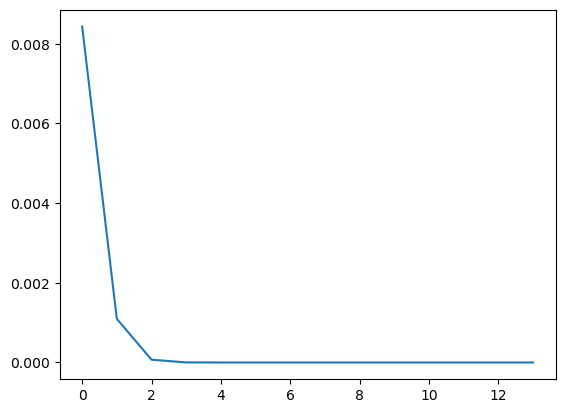

In [133]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

## Avaliando o modelo

Calculando a raiz do erro quadrádico médio

In [138]:
from sklearn.metrics import root_mean_squared_error

model_output_list = []
target_purchase_list = []

model.eval()

with torch.no_grad():

    for index, test_data in enumerate(test_loader):
        # calculando tamanho do lote retornado
        batch_length = len(test_data['customers'])
        # predições do modelo (y-predito)
        output = model(test_data['customers'], test_data['products'])
        # armazenando o erro do modelo
        model_output_list.append(output.sum().item() / batch_length)
        # recuperando valor original (y-verdadeiro)
        target_purchase = test_data['purchases']
        target_purchase_list.append(target_purchase.sum().item() / batch_length)

rms = root_mean_squared_error(target_purchase_list, model_output_list)
rms

0.0789485662720172

precisão e recall dos K-produtos (Precision@K and Recall@K)

In [ ]:
from collections import defaultdict

customer_pred_true = defaultdict(list)

with torch.no_grad():

    for i, test_data in enumerate(test_loader):

        customers = test_data['customers']
        products = test_data['products']
        purchases = test_data['purchases']

        output = model(customers, products)

        for j in range(len(customers)):

            customer_id = customers[j].item()
            product_id = products[j].item()

            pred_purchase_count = output[j][0].item()
            true_purchase_count = purchases[j].item()

            customer_pred_true[customer_id].append((pred_purchase_count, true_purchase_count))
            print(f'customer_id: {customer_id}; product_id: {product_id}; true_purchase_count: {true_purchase_count}; pred_purchase_count: {pred_purchase_count}')

customer_id: 80269; product_id: 29334; true_purchase_count: 2; pred_purchase_count: 1.15959632396698
customer_id: 11737; product_id: 31907; true_purchase_count: 1; pred_purchase_count: 1.0520983934402466
customer_id: 28536; product_id: 6950; true_purchase_count: 1; pred_purchase_count: 1.0868556499481201
customer_id: 18022; product_id: 10707; true_purchase_count: 1; pred_purchase_count: 1.0842341184616089
customer_id: 77910; product_id: 2359; true_purchase_count: 1; pred_purchase_count: 1.0609769821166992
customer_id: 93989; product_id: 7241; true_purchase_count: 1; pred_purchase_count: 1.0468441247940063
customer_id: 81239; product_id: 22012; true_purchase_count: 1; pred_purchase_count: 1.180005669593811
customer_id: 91027; product_id: 10940; true_purchase_count: 1; pred_purchase_count: 1.056774377822876
customer_id: 63915; product_id: 8377; true_purchase_count: 1; pred_purchase_count: 1.2203904390335083
customer_id: 40620; product_id: 9651; true_purchase_count: 1; pred_purchase_count

In [173]:
with torch.no_grad():

    precisions = dict()
    recalls = dict()

    k=100
    threshold=1

    for uid, customer_purchase_count in customer_pred_true.items():

        # ordenando as predições de produtos comprados por cliente
        customer_purchase_count.sort(key=lambda x: x[0], reverse=True)
        # registrando o número de produtos relevantes
        n_rel = sum((true_p >= threshold) for (_, true_p) in customer_purchase_count)
        # regitrando o número de produtos recomendados que foram preditos como relevantes para o top K produtos
        n_rec_k = sum((pred >= threshold) for (pred, _) in customer_purchase_count[:k])
        # registrando o número de produtos recomendados que são realmente relevantes para o top K produtos
        n_rec_and_rec_k = sum(
            ((true_p >= threshold) and (pred >= threshold))
            for (pred, true_p) in customer_purchase_count[:k]
        )

        print(f'uid: {uid}; n_rel: {n_rel}; n_rec_k: {n_rec_k}; n_rec_and_rec_k: {n_rec_and_rec_k}')

        # proporção de produtos recomendados que são relevantes
        precisions[uid] = n_rec_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        # proporção de produtos relevantes que foram recomendados
        recalls[uid] = n_rec_and_rec_k / n_rel if n_rel != 0 else 0

uid: 80269; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 11737; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 28536; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 18022; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 77910; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 93989; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 81239; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 91027; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 63915; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 40620; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 37282; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 49271; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 39411; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 61100; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 46120; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 52266; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 90378; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 49858; n_rel: 1; n_rec_k: 1; n_rec_and_rec_k: 1
uid: 65852; n_rel: 1; n_rec_k: 1; n_rec_and_re

In [174]:
print(f'Precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}')
print(f'Recall @ {k}: {sum(rec for rec in recalls.values()) / len(recalls)}')

Precision @ 100: 0.9542278127183788
Recall @ 100: 0.9538201723736315
